In [1]:
!pip install tqdm
!pip install seaborn
!pip install fpdf2

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline

import os
import h5py
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from fpdf import FPDF

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow import keras

import helper_functions as hlp
import function_read_data as rdat
import function_model_definition as md
import functions_gradcam as gc
import plot_function_gradcam as pgc

print("TF  Version",tf.__version__)

TF  Version 2.4.0


## Load Data

In [3]:
# Define the path + output path:
print(os.getcwd())
DIR = "/tf/notebooks/"
DATA_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/data/"

version = "10Fold_sigmoid" # one of "10Fold_sigmoid", "10Fold_softmax_V0", "10Fold_softmax_V1", "andrea"
generate_heatmap_and_save = False
generate_pictures = False

hm_of_pred = True # if true heatmap of prediction will be generated else heatmap of class 1

if version.startswith("10Fold"):
    WEIGHT_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/weights/" + version + "/"
    DATA_OUTPUT_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/data/" + version + "/"
    PIC_OUTPUT_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/pictures/" + version + "/"
    pic_save_name = version + "_predclgc"
    
elif version == "andrea":
    WEIGHT_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/weights/andrea_split/"
    DATA_OUTPUT_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/data/andrea_split/"
    PIC_OUTPUT_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/pictures/andrea_split/"
    pic_save_name = "andrea_split" + "_predclgc"

/tf/notebooks/brdd/xAI_stroke_3d


In [4]:
## load images and ids

if version == "andrea": ## for andrea
    with h5py.File("/tf/notebooks/hezo/stroke_zurich/data/dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5", "r") as h5:
        # with h5py.File(IMG_DIR2 + 'dicom-3d.h5', "r") as h5:
        # both images are the same
            X_in = h5["X"][:]
            pat = h5["pat"][:]
            
    # load results
    path_results = DATA_DIR + "all_tab_results_andrea_split.csv" # andrea split
    
elif version.startswith("10Fold"): ## for 10 Fold
    if version.endswith("V0") or version.endswith("sigmoid"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_sigmoid_ids.csv", sep=",")
        num_models = 5
    elif version.endswith("V1"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_softmax_ids_V1.csv", sep=",")
        num_models = 10
    pat = id_tab["p_id"].to_numpy()
    X_in = np.load(DATA_DIR + "prepocessed_dicom_3d.npy")
    
    # load results
    path_results = DATA_DIR + "all_tab_results_" + version + ".csv" # 10 Fold

all_results = pd.read_csv(path_results, sep=",")
all_results = all_results.sort_values("p_idx")

## Model

In [5]:
# define model
layer_connection = "globalAveragePooling"

if "sigmoid" in version or "andrea_split" in version:
    last_activation = "sigmoid"
    output_dim = 1
    LOSS = "binary_crossentropy"
    pred_idx = 0
elif "softmax" in version:
    last_activation = "softmax"
    output_dim = 2
    LOSS = tf.keras.losses.categorical_crossentropy
    pred_idx = 1

input_dim = (128, 128, 28, 1)
model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.compile(
    loss=LOSS,
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

def generate_model_name(which_split, model_nr, path = WEIGHT_DIR):
    return (path + "3d_cnn_binary_model_split" + str(which_split) + 
              "_unnormalized_avg_layer_paper_model_" + last_activation +
              "_activation_1" + str(model_nr) + ".h5")

# define if print should be enabled
check_print = True


# Plot GradCams

## Calculate Heatmap and Heatmap Uncertainty

In [6]:
# select all patients
p_ids = all_results["p_id"].to_numpy()

if version == "andrea":
    (res_table, res_images, res_model_names) = gc.get_img_and_models(
        p_ids, results = all_results[all_results.test_split == 6], pats = pat, imgs = X_in,
        gen_model_name = generate_model_name) # andrea split
elif version.startswith("10Fold"):
    (res_table, res_images, res_model_names) = gc.get_img_and_models(
        p_ids, results = all_results, pats = pat, imgs = X_in,
        gen_model_name = generate_model_name,
        num_models = num_models) # 10 Fold

In [7]:
vis_layers = [i.name for i in model_3d.layers[1:-6]]
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]

In [8]:
vis_layers

['conv3d', 'conv3d_1', 'conv3d_2', 'conv3d_3']

In [9]:
res_table

,index,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,...,y_pred_model_12,y_pred_model_13,y_pred_model_14,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class,y_pred_std,y_pred_unc,pred_correct
0,205,1,1,1.0,0,val,train,train,train,train,...,0.006181,0.013081,0.010683,0.014991,0.012591,0.225491,0,0.011203,0.023237,True
1,206,2,2,1.0,0,val,train,train,train,train,...,0.024134,0.049767,0.028247,0.041919,0.037599,0.225491,0,0.023930,0.066490,True
2,367,3,3,0.0,0,train,train,train,train,val,...,0.131908,0.243230,0.315786,0.214386,0.204826,0.225491,0,0.080713,0.259467,True
3,41,4,5,0.0,0,train,test,train,train,train,...,0.716669,0.567527,0.606706,0.632576,0.635252,0.225491,1,0.073403,0.234623,False
4,246,5,6,3.0,1,train,val,train,train,train,...,0.245842,0.348741,0.214166,0.255132,0.251216,0.225491,1,0.062966,0.199155,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,81,403,555,0.0,0,train,test,train,train,train,...,0.149244,0.191791,0.250303,0.174730,0.170676,0.225491,0,0.048965,0.151572,True
403,122,404,556,0.0,0,train,train,test,train,train,...,0.005016,0.002759,0.005417,0.005433,0.004173,0.225491,0,0.004365,0.000000,True
404,406,405,557,1.0,0,train,train,train,train,val,...,0.017060,0.018309,0.032593,0.021798,0.021210,0.225491,0,0.006236,0.006357,True
405,366,406,559,1.0,0,train,train,train,val,train,...,0.382259,0.497347,0.451662,0.383475,0.379759,0.225491,1,0.094122,0.305038,False


In [10]:
# lc = last conv layer
# ac = average over all conv layer

if generate_heatmap_and_save:

    heatmaps_lc = []
    max_hm_slices_lc = []
    hm_mean_stds_lc = []

    heatmaps_ac = []
    max_hm_slices_ac = []
    hm_mean_stds_ac = []

    resized_imgs = []

    model_mode = "mean"
    for i in tqdm(range(len(res_table))):
        
        if res_table["y_pred_class"][i] == 0 and hm_of_pred == True:
            invert = "last"
        else:
            invert = "none"
        
        heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
        img = res_images[i:i+1], 
        cnn = model_3d,
        model_names = res_model_names[i],
        layers = vis_layers[-1],
        model_mode = model_mode,
        pred_index = pred_idx,
        invert_hm = invert)

        heatmaps_lc.append(heatmap)
        max_hm_slices_lc.append(max_hm_slice)
        hm_mean_stds_lc.append(hm_mean_std)

        heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
        img = res_images[i:i+1], 
        cnn = model_3d,
        model_names = res_model_names[i],
        layers = vis_layers,
        model_mode = model_mode,
        pred_index = pred_idx,
        invert_hm = invert)

        heatmaps_ac.append(heatmap)
        max_hm_slices_ac.append(max_hm_slice)
        hm_mean_stds_ac.append(hm_mean_std)

        resized_imgs.append(resized_img)
        
else:
    res_table = pd.read_csv(DATA_OUTPUT_DIR + "all_tab_results_hm_unc_" + pic_save_name + ".csv",  sep = ",")
    heatmaps_lc = np.load(DATA_OUTPUT_DIR + "all_heatmaps_last_conv_layer_" + pic_save_name + ".npy")
    max_hm_slices_lc = np.load(DATA_OUTPUT_DIR + "all_max_activation_indices_last_conv_layer_" + pic_save_name + ".npy")
    heatmaps_ac = np.load(DATA_OUTPUT_DIR + "all_heatmaps_average_conv_layer_" + pic_save_name + ".npy")
    max_hm_slices_ac = np.load(DATA_OUTPUT_DIR + "all_max_activation_indices_laverage_conv_layer_" + pic_save_name + ".npy")
    

In [11]:
if generate_heatmap_and_save:
    res_table["heatmap_std_avg_layer"] = hm_mean_stds_ac
    res_table["heatmap_std_last_layer"] = hm_mean_stds_lc

    res_table["heatmap_unc_avg_layer"] = (res_table["heatmap_std_avg_layer"] - res_table.heatmap_std_avg_layer.min()) / (
        res_table.heatmap_std_avg_layer.max() - res_table.heatmap_std_avg_layer.min())
    res_table["heatmap_unc_last_layer"] = (res_table["heatmap_std_last_layer"] - res_table.heatmap_std_last_layer.min()) / (
        res_table.heatmap_std_last_layer.max() - res_table.heatmap_std_last_layer.min())

#### Evaluate Metrics

In [12]:
max_hm_slices_lc

array([[[91, 83, 13],
        [76, 83, 14],
        [99, 76, 13],
        [83, 84, 13],
        [84, 84, 14]],

       [[59, 59, 13],
        [67, 43, 14],
        [59, 44, 14],
        [76, 84, 13],
        [59, 60, 14]],

       [[68, 84, 14],
        [76, 91, 13],
        [67, 83, 13],
        [83, 92, 14],
        [68, 84, 14]],

       ...,

       [[76, 91, 14],
        [83, 91, 13],
        [76, 84, 14],
        [68, 43, 14],
        [68, 43, 14]],

       [[28, 51, 23],
        [75, 52,  4],
        [28, 83, 23],
        [76, 83,  4],
        [28, 51, 23]],

       [[36, 60, 23],
        [68, 84, 14],
        [68, 84, 14],
        [75, 91, 13],
        [67, 43, 13]]])

In [13]:
max_hm_slices_ac

array([[[85, 57, 12],
        [84, 89, 10],
        [93, 68, 25],
        [85, 89, 13],
        [76, 92, 24]],

       [[53, 83, 14],
        [49, 82, 14],
        [76, 36, 25],
        [62, 61,  1],
        [62, 60,  1]],

       [[77, 80, 24],
        [68, 76, 24],
        [83, 69, 25],
        [80, 90, 14],
        [77, 80, 24]],

       ...,

       [[54, 45, 24],
        [44, 59, 24],
        [73, 83, 25],
        [77, 91, 14],
        [44, 59, 25]],

       [[93, 75, 24],
        [52, 48, 25],
        [50, 45, 22],
        [50, 52, 23],
        [27, 64, 21]],

       [[38, 61, 23],
        [32, 67, 25],
        [77, 93, 10],
        [31, 68, 25],
        [33, 68, 23]]])

In [14]:
print(np.corrcoef(res_table["heatmap_unc_avg_layer"], res_table["heatmap_unc_last_layer"]))
print(np.corrcoef(res_table["y_pred_unc"], res_table["heatmap_unc_avg_layer"]))
print(np.corrcoef(res_table["y_pred_unc"], res_table["heatmap_unc_last_layer"]))

[[ 1.         -0.12294149]
 [-0.12294149  1.        ]]
[[ 1.         -0.33218081]
 [-0.33218081  1.        ]]
[[1.         0.44175756]
 [0.44175756 1.        ]]


[Text(0.5, 0, 'true class'), Text(0, 0.5, 'heatmap uncertainty last layer')]

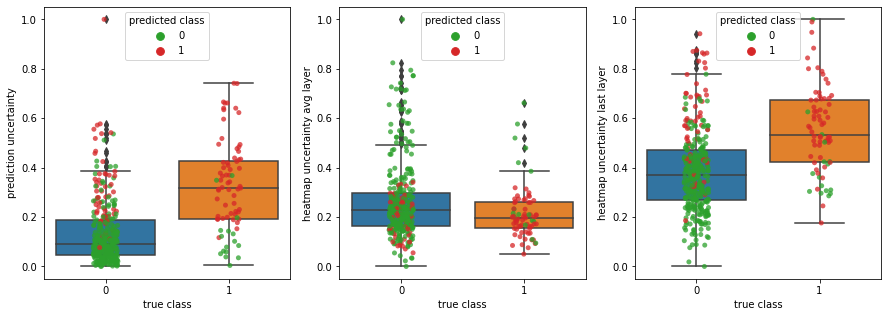

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))

sns.boxplot(x = "unfavorable",
    y = "y_pred_unc",
    data = res_table,
    ax = ax1)
sns.stripplot(x = "unfavorable",
    y = "y_pred_unc",
    hue = 'y_pred_class',
    alpha = 0.75,
    palette=["C2", "C3"],
    data = res_table,
    ax = ax1)
ax1.legend(title='predicted class', loc='upper center')
ax1.set(xlabel='true class', ylabel='prediction uncertainty')

sns.boxplot(x = "unfavorable",
    y = "heatmap_unc_avg_layer",
    data = res_table,
    ax = ax2)
sns.stripplot(x = "unfavorable",
    y = "heatmap_unc_avg_layer",
    hue = 'y_pred_class',
    alpha = 0.75,
    palette=["C2", "C3"],
    data = res_table,
    ax = ax2)
ax2.legend(title='predicted class', loc='upper center')
ax2.set(xlabel='true class', ylabel='heatmap uncertainty avg layer')

sns.boxplot(x = "unfavorable",
    y = "heatmap_unc_last_layer",
    data = res_table,
    ax = ax3)
sns.stripplot(x = "unfavorable",
    y = "heatmap_unc_last_layer",
    hue = 'y_pred_class',
    alpha = 0.75,
    palette=["C2", "C3"],
    data = res_table,
    ax = ax3)
ax3.legend(title='predicted class', loc='upper center')
ax3.set(xlabel='true class', ylabel='heatmap uncertainty last layer')

<AxesSubplot:xlabel='heatmap_unc_avg_layer', ylabel='y_pred_unc'>

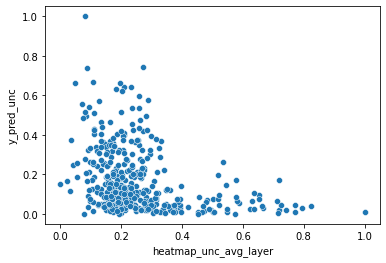

In [16]:
sns.scatterplot(
           x = "heatmap_unc_avg_layer",
           y = "y_pred_unc",
            data = res_table)

#### Save Heatmaps, Images and updated Table

In [17]:
if generate_heatmap_and_save:
    res_table.to_csv(DATA_OUTPUT_DIR + "all_tab_results_hm_unc_" + pic_save_name + ".csv",  index=False)
    np.save(DATA_OUTPUT_DIR + "all_heatmaps_last_conv_layer_" + pic_save_name + ".npy", heatmaps_lc)
    np.save(DATA_OUTPUT_DIR + "all_max_activation_indices_last_conv_layer_" + pic_save_name + ".npy", max_hm_slices_lc)
    np.save(DATA_OUTPUT_DIR + "all_heatmaps_average_conv_layer_" + pic_save_name + ".npy", heatmaps_ac)
    np.save(DATA_OUTPUT_DIR + "all_max_activation_indices_laverage_conv_layer_" + pic_save_name + ".npy", max_hm_slices_ac)

## Plot Average Heatmaps

In [18]:
idx = np.where(res_table["y_pred_class"] == 0)

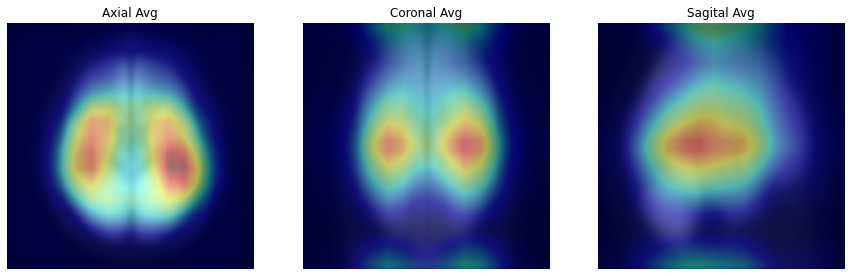

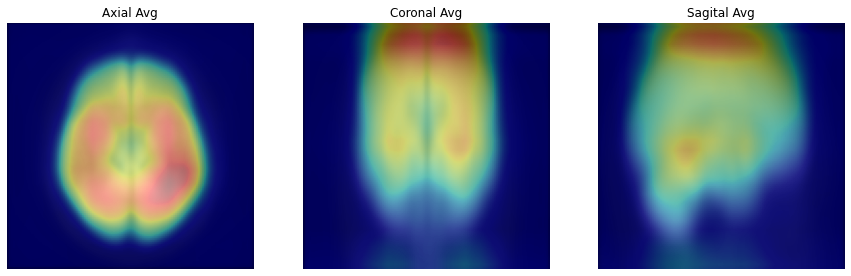

In [19]:
mean_hm_lc = np.array(np.take(heatmaps_lc, idx, axis = 0).squeeze()).mean(axis = 0)
mean_hm_ac = np.array(np.take(heatmaps_ac, idx, axis = 0).squeeze()).mean(axis = 0)
mean_image = np.array(np.take(res_images, idx, axis = 0).squeeze()).mean(axis = 0)

pgc.plot_gradcam(mean_image, mean_hm_lc,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(mean_image, mean_hm_ac,
            version = "overlay",
            mode = "avg")

In [20]:
idx = np.where(res_table["y_pred_class"] == 1)

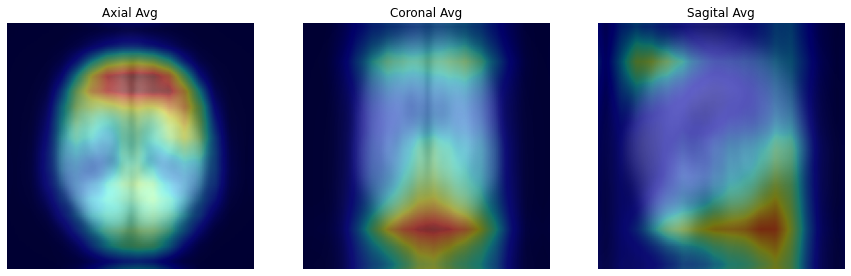

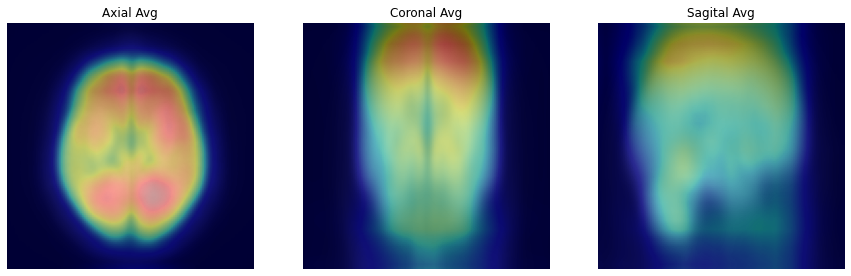

In [21]:
mean_hm_lc = np.array(np.take(heatmaps_lc, idx, axis = 0).squeeze()).mean(axis = 0)
mean_hm_ac = np.array(np.take(heatmaps_ac, idx, axis = 0).squeeze()).mean(axis = 0)
mean_image = np.array(np.take(res_images, idx, axis = 0).squeeze()).mean(axis = 0)

pgc.plot_gradcam(mean_image, mean_hm_lc,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(mean_image, mean_hm_ac,
            version = "overlay",
            mode = "avg")

In [22]:
idx = np.arange(0,407)

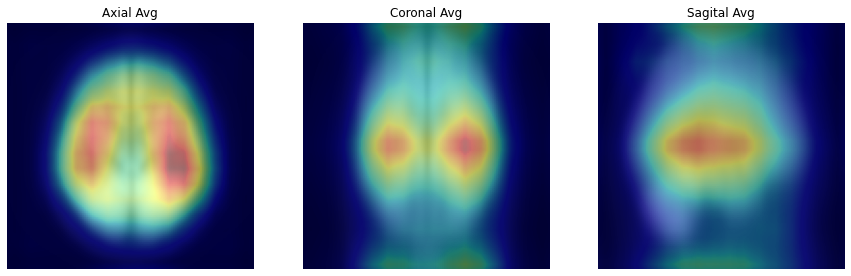

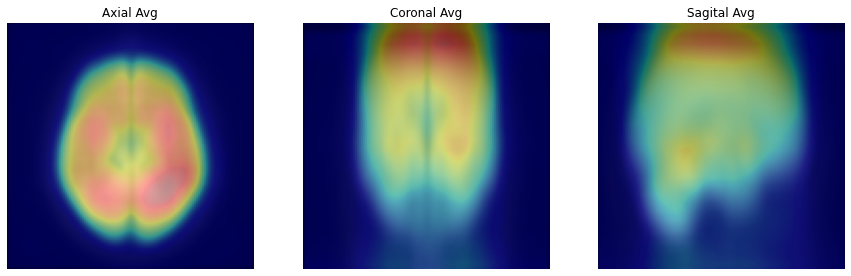

In [23]:
mean_hm_lc = np.array(np.take(heatmaps_lc, idx, axis = 0).squeeze()).mean(axis = 0)
mean_hm_ac = np.array(np.take(heatmaps_ac, idx, axis = 0).squeeze()).mean(axis = 0)
mean_image = np.array(np.take(res_images, idx, axis = 0).squeeze()).mean(axis = 0)

pgc.plot_gradcam(mean_image, mean_hm_lc,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(mean_image, mean_hm_ac,
            version = "overlay",
            mode = "avg")

## Save Plots as PNG

In [24]:
if generate_pictures:
    pgc.plot_gradcams_last_avg_org(
        res_table = res_table, 
        vis_layers = vis_layers,
        res_images = res_images,
        res_model_names = res_model_names,
        model_3d = model_3d,
        layer_mode = "mean", 
        heatmap_mode = "avg", 
        save_path = PIC_OUTPUT_DIR, 
        save_name = pic_save_name, save = True)

In [25]:
if generate_pictures:
    pgc.plot_gradcams_last_avg_org(
        res_table = res_table, 
        vis_layers = vis_layers,
        res_images = res_images,
        res_model_names = res_model_names,
        model_3d = model_3d,
        layer_mode = "mean", 
        heatmap_mode = "max", 
        save_path = PIC_OUTPUT_DIR, 
        save_name = pic_save_name, save = True)

## Save Plots into PDF

In [26]:
# ## all ids
# wrong_out = False
# pat_ids = list(res_table["p_id"])

In [27]:
## only ids with low uncertainty and wrong classified
wrong_out = True
pat_ids = list(res_table.query("pred_correct == False and y_pred_unc < 0.2").p_id)
res_table[res_table.p_id.isin(pat_ids)].to_csv(
    DATA_OUTPUT_DIR + "all_tab_results_hm_unc_" + pic_save_name + "_wrong_cl.csv",  index=False)

In [28]:
res_table[res_table.p_id.isin(pat_ids)]

,index,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,...,y_pred_trafo_avg,threshold,y_pred_class,y_pred_std,y_pred_unc,pred_correct,heatmap_std_avg_layer,heatmap_std_last_layer,heatmap_unc_avg_layer,heatmap_unc_last_layer
8,247,9,13,2.0,0,train,val,train,train,train,...,0.270336,0.225491,1,0.047245,0.145727,False,0.053222,0.070727,0.156280,0.588827
9,248,10,14,0.0,0,train,val,train,train,train,...,0.607988,0.225491,1,0.058905,0.185354,False,0.044612,0.047945,0.109921,0.290338
28,43,29,39,0.0,0,train,test,train,train,train,...,0.292006,0.225491,1,0.028454,0.081864,False,0.069407,0.058317,0.243430,0.426231
33,3,34,44,1.0,0,test,train,train,train,train,...,0.246278,0.225491,1,0.025178,0.070731,False,0.082877,0.062250,0.315962,0.477771
44,46,45,58,6.0,1,train,test,train,train,train,...,0.168685,0.225491,0,0.047280,0.145846,False,0.058754,0.066509,0.186070,0.533570
75,48,76,109,0.0,0,train,test,train,train,train,...,0.343566,0.225491,1,0.039773,0.120332,False,0.075618,0.074482,0.276876,0.638034
92,259,93,132,0.0,0,train,val,train,train,train,...,0.478176,0.225491,1,0.055193,0.172738,False,0.063692,0.071496,0.212658,0.598904
103,9,104,148,0.0,0,test,train,train,train,train,...,0.267471,0.225491,1,0.043167,0.131867,False,0.061946,0.059228,0.203259,0.438165
119,174,120,169,0.0,0,train,train,train,train,test,...,0.443928,0.225491,1,0.057872,0.181841,False,0.061029,0.079280,0.198321,0.700887
181,99,182,240,1.0,0,train,train,test,train,train,...,0.262809,0.225491,1,0.059170,0.186253,False,0.072673,0.075195,0.261017,0.647369


In [29]:
pdf = FPDF()
pdf.set_auto_page_break(0)

# imagelist is the list with all image filenames
for patient in tqdm(pat_ids):
    pdf.add_page(orientation = "L", format = "A4")
    
    name_start = PIC_OUTPUT_DIR + "pat" + str(patient) + "_" + pic_save_name
    
    x,y,w,h = (0,10,160,160)
    pdf.image(name_start + "_last_and_all_layers_avg.png", x,y,w,h)
    x,y,w,h = (140,10,160,160)
    pdf.image(name_start + "_last_and_all_layers_max.png", x,y,w,h)
    
if wrong_out:
    pdf.output(PIC_OUTPUT_DIR + "10Fold_ensembling" + pic_save_name[6:] + "_all_patients_wrong_cl.pdf", "F")
else:
    pdf.output(PIC_OUTPUT_DIR + "10Fold_ensembling" + pic_save_name[6:] + "_all_patients.pdf", "F")


100%|██████████| 25/25 [00:07<00:00,  3.14it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: "dest" parameter is deprecated, unused and will soon be removed
  app.launch_new_instance()
